In [2]:
import numpy as np
import yaml
from collections import defaultdict
import random

from bokeh.plotting import figure, output_notebook, show
import beer
import pickle

output_notebook()

Loading BokehJS ...

In [4]:
%%bash
pwd

/mnt/matylda5/iondel/workspace/2019/gsm/beer/recipes/aud


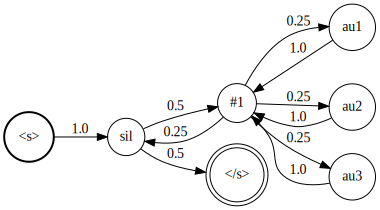

In [7]:
with open('test_graph.pkl', 'rb') as f:
    graph = pickle.load(f)
graph

In [80]:
def load_transcript(path):
    with open(path, 'r') as f:
        trans = {}
        for line in f:
            tokens = line.strip().split()
            trans[tokens[0]] = tokens[1:]
    return trans

def get_durations(trans, max_duration=100):
    current = trans[0]
    durations = np.zeros(max_duration)
    duration = 1
    for token in trans[1:]:
        if token == current:
            duration += 1
        else:
            current = token
            durations[min(duration, max_duration - 1)] += 1
            duration = 1
    return durations

ref = load_transcript('exp/timit/monophone_mbn_babel/align_ac1.0/train/trans')
durations = np.zeros(100)
for utt, trans in ref.items():
    trans = list(filter(lambda a: a != 'sil', trans))
    durations += get_durations(trans, len(durations))
durations /= durations.sum()

hyp = load_transcript('exp/timit/aud_8g/decode_perframe_ac1.0/train/trans')
hyp_durations = np.zeros(len(durations))
for utt, trans in hyp.items():
    trans = list(filter(lambda a: a != 'sil', trans))
    hyp_durations += get_durations(trans, len(hyp_durations))
hyp_durations /= hyp_durations.sum()

hyp = load_transcript('exp/timit/aud_4g/decode_perframe_ac1.0/train/trans')
hyp_durations2 = np.zeros(len(durations))
for utt, trans in hyp.items():
    trans = list(filter(lambda a: a != 'sil', trans))
    hyp_durations2 += get_durations(trans, len(hyp_durations2))
hyp_durations2 /= hyp_durations2.sum()

fig = figure(x_range=(0, 40))
fig.vbar(x=range(len(durations)), top=durations, width=0.9, alpha=0.5)
fig.vbar(x=range(len(hyp_durations)), top=hyp_durations, width=0.9, alpha=0.5, color='red')
fig.vbar(x=range(len(hyp_durations2)), top=hyp_durations2, width=0.9, alpha=0.5, color='green')
show(fig)

In [3]:
with open('conf/hmm.yml', 'r') as f:
    conf = yaml.load(f)
topo = conf[1]['topology']
state_ids = set([arc['start_id'] for arc in topo] + [arc['end_id'] for arc in topo])
state_ids = sorted(list(state_ids))
graph = beer.graph.Graph()

for i in range(len(state_ids)):
    if i > 0 and i < len(state_ids) - 1:
        graph.add_state(pdf_id=i)
    else:
        graph.add_state()
graph.start_state = states[0]
graph.end_state = states[-1]
for arc in topo:
    graph.add_arc(arc['start_id'], arc['end_id'], weight=arc['trans_prob'])
graph

NameError: name 'states' is not defined

In [75]:
alpha = .75
skip = .0
trans_probs = np.array([
    [alpha, 1 - (alpha + skip),  skip],
    [0.,  alpha, 1 - alpha],
    [0.,  0.,  alpha],
])
print(trans_probs)

def sample(state, trans_probs):
    if state == len(trans_probs) - 1:
        prob_loop = trans_probs[state, state]
        return random.choices([state, state + 1], weights=[prob_loop, 1 - prob_loop])[0]
    else:
        return random.choices(range(len(trans_probs)), weights=trans_probs[state])[0]


sample_durations = np.zeros(100)
for i in range(15000):
    seq = [0]
    while seq[-1] < 3:
        seq.append(sample(seq[-1], trans_probs))
    sample_durations[len(seq)] += 1
sample_durations = np.array(sample_durations)
sample_durations /= sample_durations.sum()

[[0.75 0.25 0.  ]
 [0.   0.75 0.25]
 [0.   0.   0.75]]


In [82]:
fig = figure(x_range=(0, 40))
fig.vbar(x=range(len(sample_durations)), top=sample_durations, width=0.9, alpha=0.5, color='salmon')
#fig.vbar(x=range(len(durations)), top=durations, width=0.9, alpha=0.5)
fig.vbar(x=range(len(hyp_durations)), top=hyp_durations, width=0.9, alpha=0.5, color='blue')
#fig.vbar(x=range(len(hyp_durations2)), top=hyp_durations2, width=0.9, alpha=0.5, color='green')
show(fig)

In [58]:
sample_durations

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,